In [1]:
%matplotlib inline
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import pandas as pd
from sctools import integrate, plot, io

Global seed set to 0


## Integration of T-cell subsets for identification of regulatory T-cells
Here we extract the identified T-cell subset from the original dataset and integrate it anew to avoid incorporating artifacts introduced into the embedding by other celltypes we are not interested in.

In [2]:
# load data
prefixes = ['tissue.scps', 'pbmc.scps']
adatas = {}
for key in prefixes:
    adata = io.initialize_from_raw(f'../data/{key}.integrated.clustered.h5ad')
    adatas[key] = adata[adata.obs.coarse_cell_types == 'Tcell'].copy()
    del adata
    
adatas

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'tissue.scps': AnnData object with n_obs × n_vars = 62462 × 20912
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types',
 'pbmc.scps': AnnData object with n_obs × n_vars = 18557 × 15998
     obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.3', 'coarse_cell_types'}

In [3]:
tissue_genes = set(adatas['tissue.scps'].var.index)
pbmc_genes = set(adatas['pbmc.scps'].var.index)
common_genes = tissue_genes & pbmc_genes
len(common_genes)

15818

In [4]:
import anndata as ad

adata = ad.concat(
    [
        adatas['tissue.scps'][:, list(common_genes)],
        adatas['pbmc.scps'][:, list(common_genes)]
    ]
)
adata

AnnData object with n_obs × n_vars = 81019 × 15818
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'coarse_cell_types'

In [5]:
adata.obs['tissue_harmonized'] = adata.obs.tissue.apply(
    lambda x: 'blood' if x.lower() == 'blood' else 'skin'
)

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/users/daniel.malzl/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/st

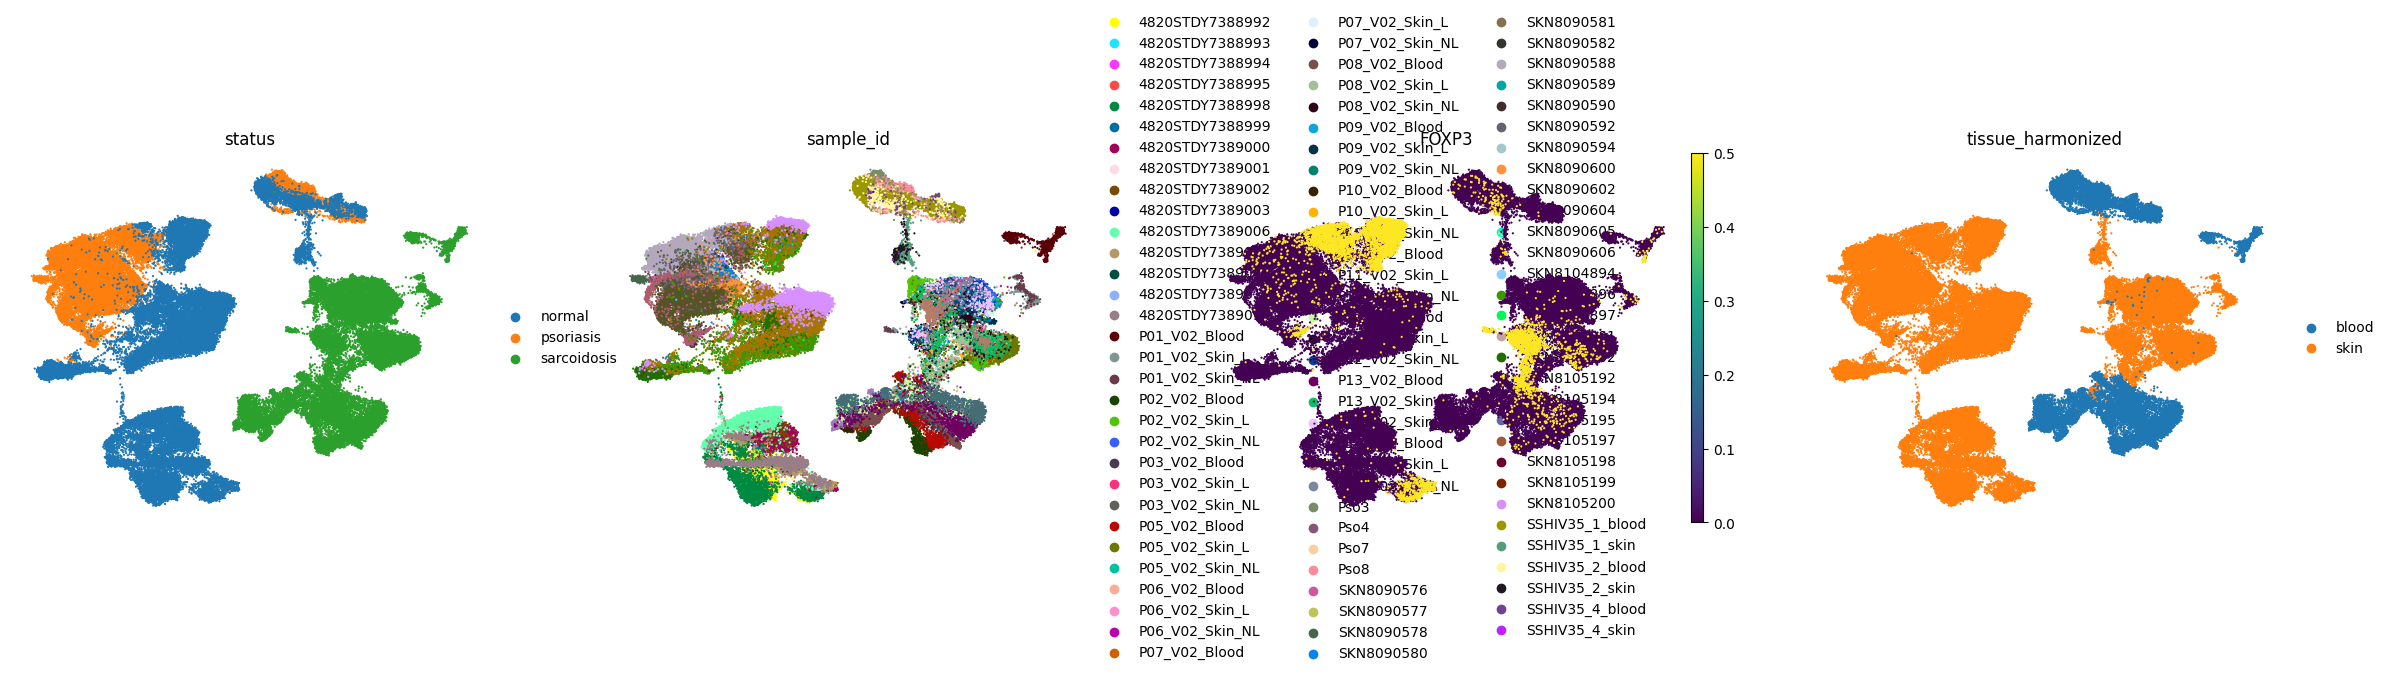

In [6]:
# visualize raw data
%matplotlib inline
plot.integrate.raw_data_umap(
    adata,
    ['status', 'sample_id', 'FOXP3', 'tissue_harmonized'],
    size = 10,
    vmax = 0.5,
    savefile = f'../plots/tcells.tissue_pbmc.raw.umap.png'
)

In [7]:
# integrate tcells
params = {'kwargs': dict()}
integration_results = {}
key = 'tissue_pbmc.scps'
integration_results[key] = integrate.integrate_data_scvi(
    adata.copy(),
    'sample_id',
    train_size = 1,
    **params['kwargs'],
    use_highly_variable_genes = False
)

integration_results[key]['data'].write(
    f'../data/{key}.integrated.h5ad'
)

integration_results[key]['model'].save(
    f'../data/{key}.integration.scvi.model',
    overwrite = True
)

filtered the following batches < 5 cells:
 sample_id
4820STDY7388993    2
4820STDY7388995    4
4820STDY7389001    1
4820STDY7389003    3
SKN8090577         2
SKN8090581         1
SKN8090589         3
SKN8090605         2
SKN8104894         1
SKN8105192         1
SKN8105197         4
SKN8105198         2
SSHIV35_4_skin     4
Name: patient_id, dtype: int64


/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/99:   0%|          | 0/99 [00:00<?, ?it/s]

/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 99/99: 100%|██████████| 99/99 [17:14<00:00, 10.45s/it, loss=4.04e+03, v_num=1]
compute umap from scvi embedding


In [2]:
# restore results if kernel breaks or gets shut down
integration_results = {}
key = 'tissue_pbmc.scps'
data = sc.read_h5ad(
    f'../data/{key}.integrated.h5ad'
)
integration_results[key] = {
    'data': data,
    'model': scvi.model.SCVI.load(
        f'../data/{key}.integration.scvi.model', 
        adata = data
    )
}
integration_results

/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained

{'tissue_pbmc.scps': {'data': AnnData object with n_obs × n_vars = 80989 × 15818
      obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'coarse_cell_types', 'tissue_harmonized'
      uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
      obsm: 'X_scvi', 'X_umap'
      layers: 'counts'
      obsp: 'connectivities', 'distances',
  'model': }}

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

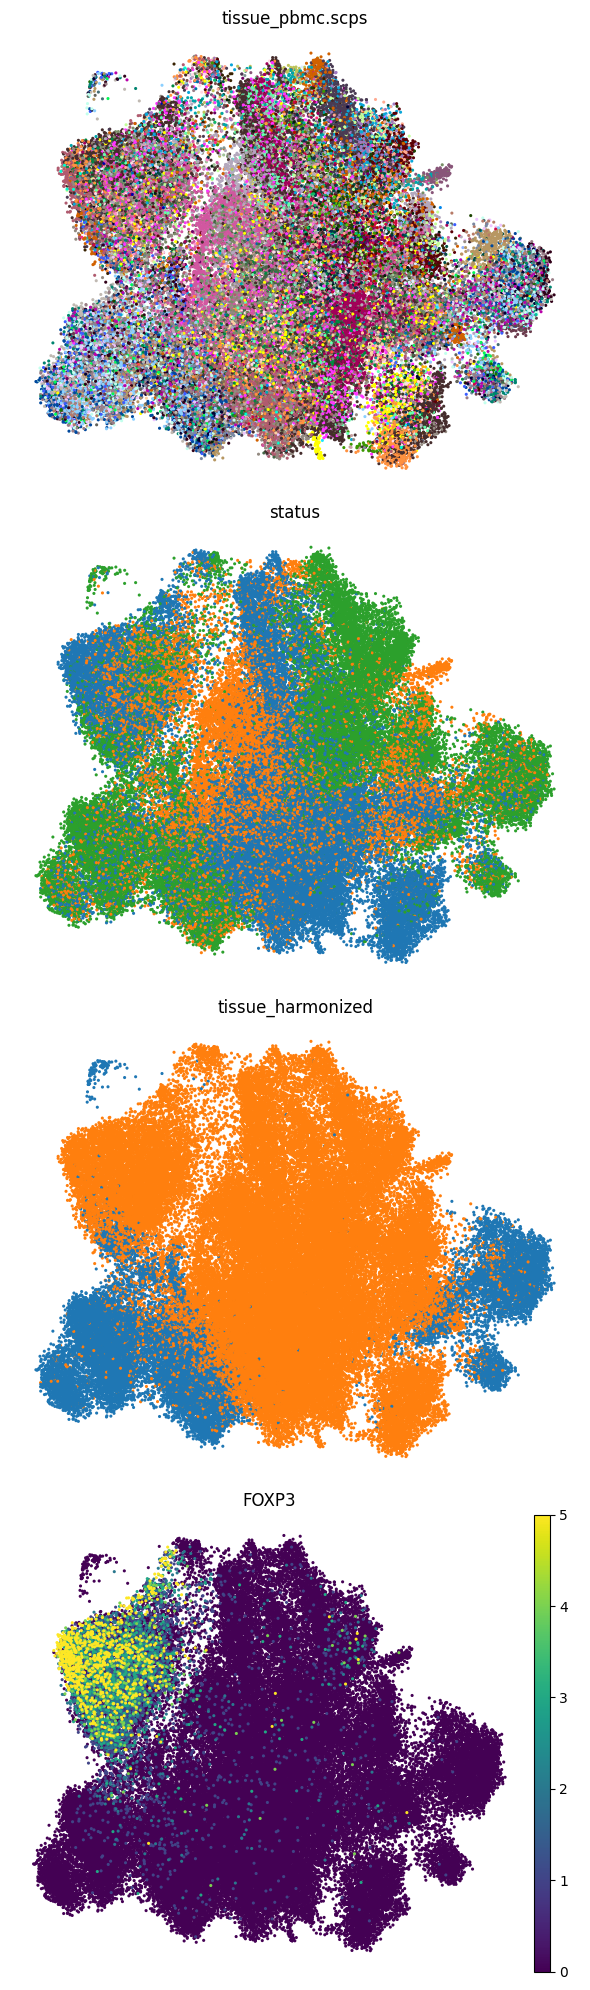

In [9]:
fig, axs = plot.integrate.plot_integration_results(
    integration_results,
    ['sample_id', 'status', 'tissue_harmonized', 'FOXP3'],
    [
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = None),
        dict(size = 20, vmax = 1),
        dict(size = 20, vmax = 5)
    ],
    data_key = 'data',
    legend_off = True
)
fig.savefig('../plots/tcells.tissue_pbmc.scps.integration.results.png')

## Treg annotation

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModification

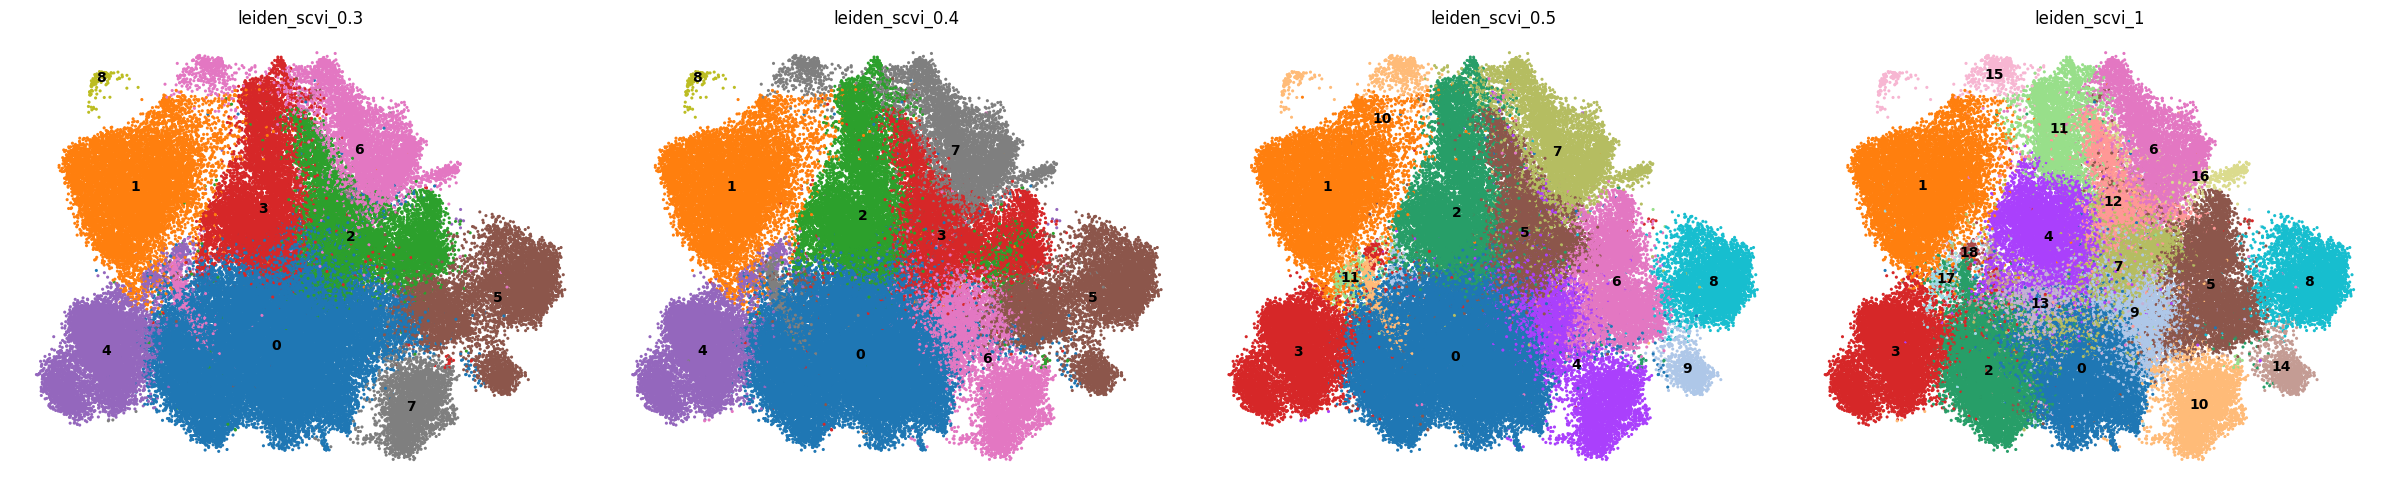

In [10]:
fig, axs = plot.integrate.plot_leiden_clusterings(
    integration_results,
    [0.3, 0.4, 0.5, 1],
    data_key = 'data',
    legend_loc = 'on data',
    size = 20
)
fig.savefig('../plots/tcells.tissue_pbmc.scps.cluster.inspect.png')

In [ ]:
resolutions = {
    'tissue_pbmc.scps': 0.3
}
for k, d in integration_results.items():
    resolution = resolutions[k]
    sc.tl.leiden(
        d['data'], 
        key_added = f'leiden_scvi_{resolution}',
        resolution = resolution
    )

/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


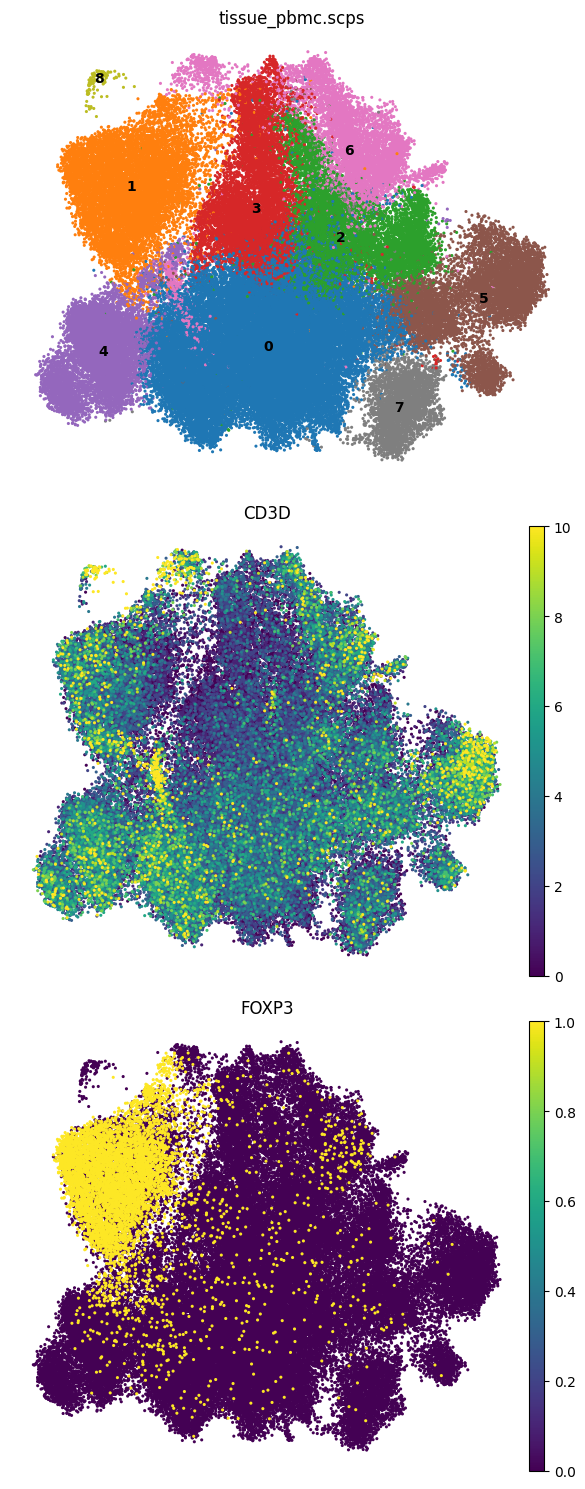

In [15]:
cluster_keys = {k: f'leiden_scvi_{r}' for k, r in resolutions.items()}
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    cluster_keys,
    ['CD3D', 'FOXP3'],
    [
        dict(size = 20, vmax = None, legend_loc = 'on data'),
        dict(size = 20, vmax = 10),
        dict(size = 20, vmax = 1)
    ],
    data_key = 'data'
)
fig.savefig('../plots/tcells.tissue_pbmc.scps.cluster.results.png')

In [16]:
treg_clusters = {
    'tissue_pbmc.scps': '1',
}

treg_clusters = {
    k: [c for c in cs.split(',')] for k, cs in treg_clusters.items()
}

tissue_pbmc.scps t_cell_types
Treg     10202
other    70787
Name: sample_id, dtype: int64


/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


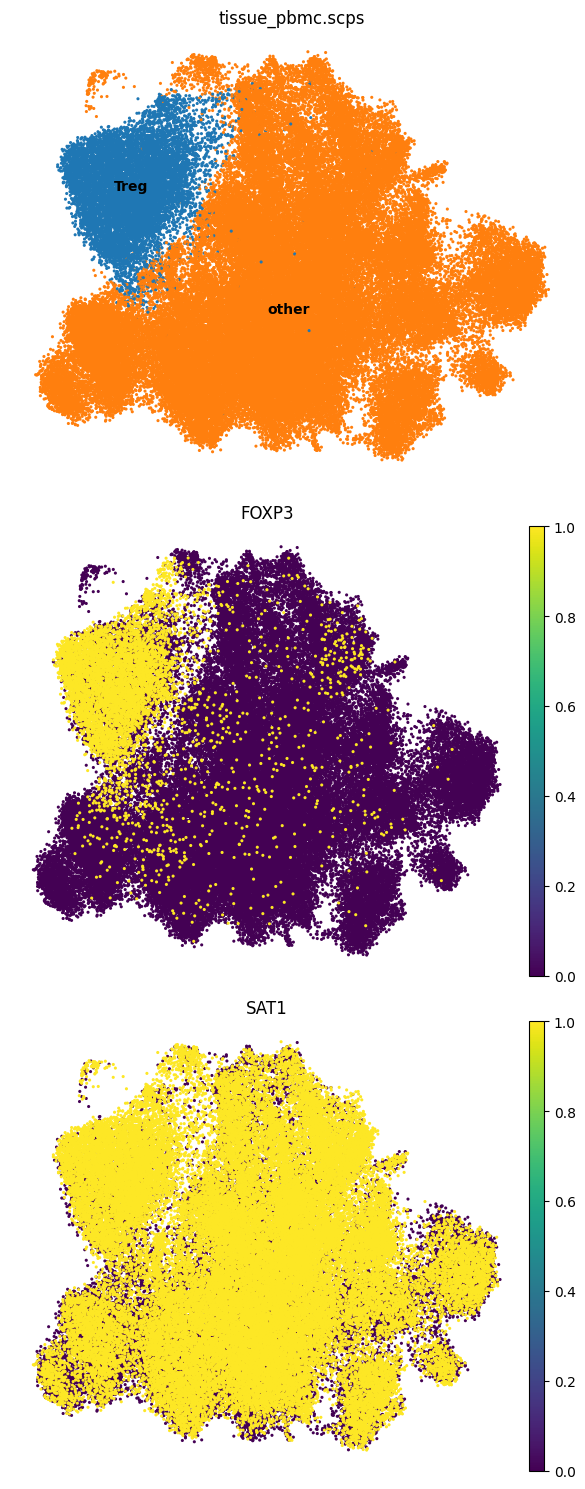

In [17]:
for k, d in integration_results.items():
    clustering = cluster_keys[k]
    d['data'].obs['t_cell_types'] = d['data'].obs[clustering].apply(
        lambda x: 'Treg' if x in treg_clusters[k] else 'other'
    )
    print(k, d['data'].obs.groupby('t_cell_types').count().iloc[:, 0])
    
fig, axs = plot.integrate.plot_clustering_and_expression(
    integration_results,
    {k: 't_cell_types' for k in integration_results.keys()},
    ['FOXP3', 'SAT1'],
    [
        dict(size = 20, vmax = None, legend_loc = 'on data'),
        dict(size = 20, vmax = 1),
        dict(size = 20, vmax = 1)
    ],
    data_key = 'data'
)
fig.savefig('../plots/tcells.tissue_pbmc.scps.cluster.treg.png')

In [18]:
for k, d in integration_results.items():
    d['data'].write(
        f'../data/{k}.integrated.clustered.h5ad'
    )

## Transfer annotations from skin

In [2]:
skin = sc.read_h5ad(
    '../data/tcells.tissue.scps.integrated.annotated.h5ad'
)
adata = sc.read_h5ad(
    '../data/tissue_pbmc.scps.integrated.clustered.h5ad'
)

In [3]:
adata.obs.drop(
    columns = ['t_cell_types'],
    inplace = True
)
transfered_annotation = adata.obs.merge(
    skin.obs.t_cell_types,
    left_index = True,
    right_index = True,
    how = 'left'
)

transfered_annotation

sample_id patient_id       status  tissue  \
AAACCTGAGTACGTTC-2    4820STDY7388992         s1       normal  dermis   
AAACCTGGTACGAAAT-2    4820STDY7388992         s1       normal  dermis   
AAACCTGTCCCTTGCA-2    4820STDY7388992         s1       normal  dermis   
AAACGGGTCAGCTCTC-2    4820STDY7388992         s1       normal  dermis   
AAACGGGTCGGCTACG-2    4820STDY7388992         s1       normal  dermis   
...                               ...        ...          ...     ...   
TTTGACTCACTTGTGA-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGATCTCAGTGCGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGATCTCTACGGGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGTTGCAATTGCTG-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGTTGTCAGTGCGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   

                        cell_fraction  doublet  doublet_score  nFeature_RNA  \
AAACCTGAGTACGTTC-2    dermal lymphoid    False   1.854074e-10           784   
AAACCTGGTACGAAAT-2    dermal lymphoid    False   1.606967e-01          1185   
AAACCTGTCCCTTGCA-2    dermal lymphoid    False   4.571165e-08           973   
AAACGGGTCAGCTCTC-2    dermal lymphoid    False   7.149967e-02          1097   
AAACGGGTCGGCTACG-2    dermal lymphoid    False   5.991189e+00          1441   
...                               ...      ...            ...           ...   
TTTGACTCACTTGTGA-165             None    False   6.411471e-02          1895   
TTTGATCTCAGTGCGC-165             None    False   4.980889e-06          1984   
TTTGATCTCTACGGGC-165             None    False   2.375286e+01          2815   
TTTGTTGCAATTGCTG-165             None    False   1.742374e-02          2344   
TTTGTTGTCAGTGCGC-165             None    False   2.113153e-04          1143   

                      nCount_RNA  percent_mt  percent_ribo  qc_pass  \
AAACCTGAGTACGTTC-2        2472.0    4.328479     44.619741     True   
AAACCTGGTACGAAAT-2        3325.0    5.654135     28.661654     True   
AAACCTGTCCCTTGCA-2        2549.0    2.628482     37.779521     True   
AAACGGGTCAGCTCTC-2        3135.0    5.390750     40.606061     True   
AAACGGGTCGGCTACG-2        5209.0    8.504511     36.897677     True   
...                          ...         ...           ...      ...   
TTTGACTCACTTGTGA-165      4664.0    5.381647     23.263293     True   
TTTGATCTCAGTGCGC-165      8040.0    5.708955     43.333333     True   
TTTGATCTCTACGGGC-165     10800.0    6.157407     36.314815     True   
TTTGTTGCAATTGCTG-165      5867.0    5.317880     15.868417     True   
TTTGTTGTCAGTGCGC-165      3232.0    8.137376     41.707921     True   

                      _scvi_batch  _scvi_labels coarse_cell_types  \
AAACCTGAGTACGTTC-2              0             0             Tcell   
AAACCTGGTACGAAAT-2              0             0             Tcell   
AAACCTGTCCCTTGCA-2              0             0             Tcell   
AAACGGGTCAGCTCTC-2              0             0             Tcell   
AAACGGGTCGGCTACG-2              0             0             Tcell   
...                           ...           ...               ...   
TTTGACTCACTTGTGA-165           47             0             Tcell   
TTTGATCTCAGTGCGC-165           47             0             Tcell   
TTTGATCTCTACGGGC-165           47             0             Tcell   
TTTGTTGCAATTGCTG-165           47             0             Tcell   
TTTGTTGTCAGTGCGC-165           47             0             Tcell   

                     tissue_harmonized leiden_scvi_0.3  \
AAACCTGAGTACGTTC-2                skin               4   
AAACCTGGTACGAAAT-2                skin               2   
AAACCTGTCCCTTGCA-2                skin               0   
AAACGGGTCAGCTCTC-2                skin               0   
AAACGGGTCGGCTACG-2                skin               0   
...                                ...             ...   
TTTGACTCACTTGTGA-165             blood               5   
TTTGATCTCAGTGCGC-165             blood               4  

In [4]:
def assign_majority(group, agg_column):
    return group[agg_column].value_counts().idxmax()
    

cluster_celltype_map = transfered_annotation \
    .loc[:, ['leiden_scvi_0.3', 't_cell_types']] \
    .groupby('leiden_scvi_0.3') \
    .agg(assign_majority, agg_column = 't_cell_types') \
    .t_cell_types.to_dict()

cluster_celltype_map

{'0': 'activated CD4',
 '1': 'regulatory T',
 '2': 'homeostatic CD8 resident memory T cells',
 '3': 'activated CD4',
 '4': 'activated CD4',
 '5': 'activated resident memory CD8',
 '6': 'effector memory CD4 Th17',
 '7': 'gamma-delta T cells',
 '8': 'activated CD4'}

In [5]:
adata.obs.loc[:, 't_cell_types'] = adata.obs['leiden_scvi_0.3'].apply(
    lambda x: cluster_celltype_map[x]
)
adata.obs

sample_id patient_id       status  tissue  \
AAACCTGAGTACGTTC-2    4820STDY7388992         s1       normal  dermis   
AAACCTGGTACGAAAT-2    4820STDY7388992         s1       normal  dermis   
AAACCTGTCCCTTGCA-2    4820STDY7388992         s1       normal  dermis   
AAACGGGTCAGCTCTC-2    4820STDY7388992         s1       normal  dermis   
AAACGGGTCGGCTACG-2    4820STDY7388992         s1       normal  dermis   
...                               ...        ...          ...     ...   
TTTGACTCACTTGTGA-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGATCTCAGTGCGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGATCTCTACGGGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGTTGCAATTGCTG-165    P14_V02_Blood        P14  sarcoidosis   Blood   
TTTGTTGTCAGTGCGC-165    P14_V02_Blood        P14  sarcoidosis   Blood   

                        cell_fraction  doublet  doublet_score  nFeature_RNA  \
AAACCTGAGTACGTTC-2    dermal lymphoid    False   1.854074e-10           784   
AAACCTGGTACGAAAT-2    dermal lymphoid    False   1.606967e-01          1185   
AAACCTGTCCCTTGCA-2    dermal lymphoid    False   4.571165e-08           973   
AAACGGGTCAGCTCTC-2    dermal lymphoid    False   7.149967e-02          1097   
AAACGGGTCGGCTACG-2    dermal lymphoid    False   5.991189e+00          1441   
...                               ...      ...            ...           ...   
TTTGACTCACTTGTGA-165             None    False   6.411471e-02          1895   
TTTGATCTCAGTGCGC-165             None    False   4.980889e-06          1984   
TTTGATCTCTACGGGC-165             None    False   2.375286e+01          2815   
TTTGTTGCAATTGCTG-165             None    False   1.742374e-02          2344   
TTTGTTGTCAGTGCGC-165             None    False   2.113153e-04          1143   

                      nCount_RNA  percent_mt  percent_ribo  qc_pass  \
AAACCTGAGTACGTTC-2        2472.0    4.328479     44.619741     True   
AAACCTGGTACGAAAT-2        3325.0    5.654135     28.661654     True   
AAACCTGTCCCTTGCA-2        2549.0    2.628482     37.779521     True   
AAACGGGTCAGCTCTC-2        3135.0    5.390750     40.606061     True   
AAACGGGTCGGCTACG-2        5209.0    8.504511     36.897677     True   
...                          ...         ...           ...      ...   
TTTGACTCACTTGTGA-165      4664.0    5.381647     23.263293     True   
TTTGATCTCAGTGCGC-165      8040.0    5.708955     43.333333     True   
TTTGATCTCTACGGGC-165     10800.0    6.157407     36.314815     True   
TTTGTTGCAATTGCTG-165      5867.0    5.317880     15.868417     True   
TTTGTTGTCAGTGCGC-165      3232.0    8.137376     41.707921     True   

                      _scvi_batch  _scvi_labels coarse_cell_types  \
AAACCTGAGTACGTTC-2              0             0             Tcell   
AAACCTGGTACGAAAT-2              0             0             Tcell   
AAACCTGTCCCTTGCA-2              0             0             Tcell   
AAACGGGTCAGCTCTC-2              0             0             Tcell   
AAACGGGTCGGCTACG-2              0             0             Tcell   
...                           ...           ...               ...   
TTTGACTCACTTGTGA-165           47             0             Tcell   
TTTGATCTCAGTGCGC-165           47             0             Tcell   
TTTGATCTCTACGGGC-165           47             0             Tcell   
TTTGTTGCAATTGCTG-165           47             0             Tcell   
TTTGTTGTCAGTGCGC-165           47             0             Tcell   

                     tissue_harmonized leiden_scvi_0.3  \
AAACCTGAGTACGTTC-2                skin               4   
AAACCTGGTACGAAAT-2                skin               2   
AAACCTGTCCCTTGCA-2                skin               0   
AAACGGGTCAGCTCTC-2                skin               0   
AAACGGGTCGGCTACG-2                skin               0   
...                                ...             ...   
TTTGACTCACTTGTGA-165             blood               5   
TTTGATCTCAGTGCGC-165             blood               4  

## SAT1 expression comparison

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initia

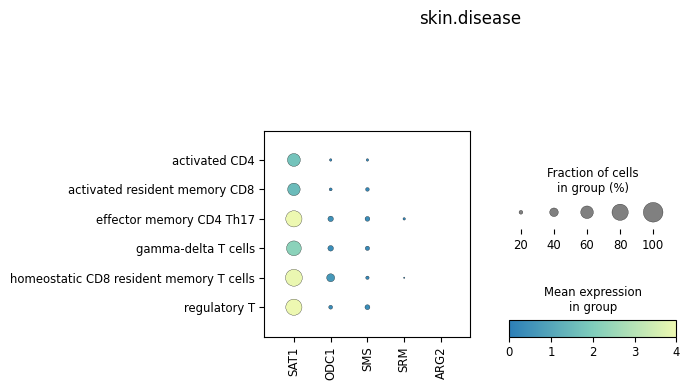

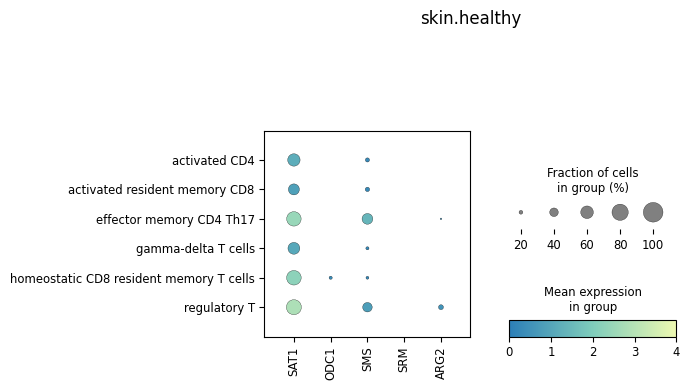

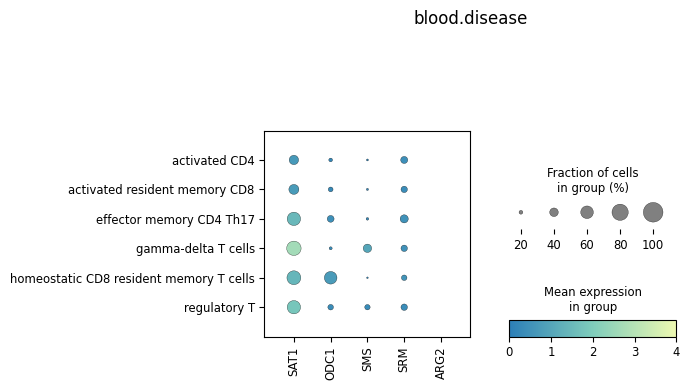

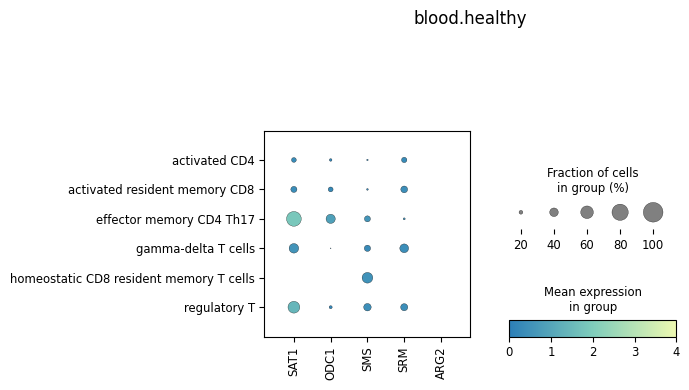

In [58]:
%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42

cmap = LinearSegmentedColormap.from_list(
    'petrols',
    ['#edf8b1', '#7fcdbb', '#2c7fb8'][::-1],
    255
)

adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(
    adata,
    target_sum = 1e4
)
sc.pp.log1p(adata)

polyamine_genes = ['SAT1', 'ODC1', 'SMS', 'SRM', 'ARG2']
for k, idx in zip(
    ['skin.disease', 'skin.healthy', 'blood.disease', 'blood.healthy'],
    [
        (adata.obs.tissue_harmonized == 'skin') & (adata.obs.status != 'normal'),
        (adata.obs.tissue_harmonized == 'skin') & (adata.obs.status == 'normal'),
        (adata.obs.tissue_harmonized == 'blood') & (adata.obs.status != 'normal'),
        (adata.obs.tissue_harmonized == 'blood') & (adata.obs.status == 'normal')
    ]
):
    fig, ax = plt.subplots()
    sc.pl.dotplot(
        adata[idx],
        groupby = 't_cell_types',
        var_names = polyamine_genes,
        ax = ax,
        expression_cutoff = 0.1,
        dot_max = 1,
        dot_min = 0.1,
        show = False, 
        vmin = 0,
        vmax = 4,
        cmap = cmap
    )
    ax.set_title(k)
    fig.set_figwidth(7)
    fig.set_figheight(4)
    fig.tight_layout()
    fig.savefig(f'../plots/dotplots/tcells_tissue_pbmc.{k}.pdf')

In [9]:
adata.obs.tissue.unique(), adata.obs.status.unique()

(['dermis', 'epidermis', 'skin', 'Skin_L', 'Skin_NL', 'blood', 'Blood']
 Categories (7, object): ['Blood', 'Skin_L', 'Skin_NL', 'blood', 'dermis', 'epidermis', 'skin'],
 ['normal', 'psoriasis', 'sarcoidosis']
 Categories (3, object): ['normal', 'psoriasis', 'sarcoidosis'])

/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/users/daniel.malzl/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


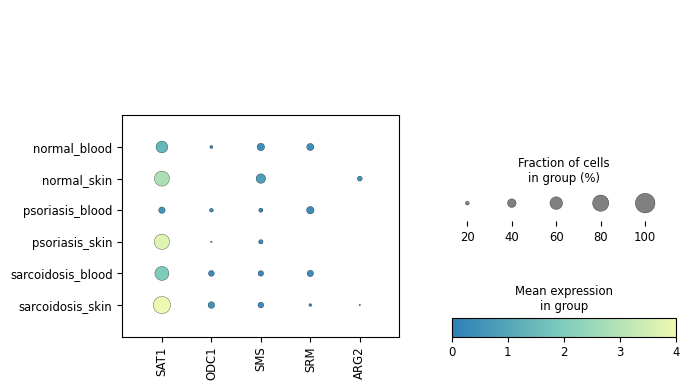

In [15]:
%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42

cmap = LinearSegmentedColormap.from_list(
    'petrols',
    ['#edf8b1', '#7fcdbb', '#2c7fb8'][::-1],
    255
)

adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(
    adata,
    target_sum = 1e4
)
sc.pp.log1p(adata)
adata.obs['data'] = adata.obs[['status', 'tissue']].apply(
    lambda x: '{}_{}'.format(x['status'], 'skin' if x['tissue'].lower() != 'blood' else 'blood'),
    axis = 1
)
polyamine_genes = ['SAT1', 'ODC1', 'SMS', 'SRM', 'ARG2']
fig, ax = plt.subplots()
sc.pl.dotplot(
    adata[adata.obs.t_cell_types == 'regulatory T'],
    groupby = 'data',
    var_names = polyamine_genes,
    ax = ax,
    expression_cutoff = 0.1,
    dot_max = 1,
    dot_min = 0.1,
    show = False, 
    vmin = 0,
    vmax = 4,
    cmap = cmap
)
fig.set_figwidth(7)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig(f'../plots/dotplots/tcells_tissue_pbmc.tregs_only.pdf')